In [2]:
import random
import torch
from d2l import torch as d2l

In [10]:
def synthetic_data(w, b, num_examples):
    # torch.normal(mean, std, size) 用于生成服从正态分布的张量
    # mean: 均值，这里为0
    # std: 标准差，这里为1
    # size: 输出张量的形状，这里为(num_examples, len(w))
    X = torch.normal(0, 1, size=(num_examples, len(w)))
    # 下面一行原代码写错了，应该是matmul而不是mutmul
    # matmul是矩阵乘法，mutmul并不存在
    y = torch.matmul(X, w) + b
    # 给y加上噪声，噪声服从均值为0，标准差为0.01的正态分布，形状与y相同
    y += torch.normal(0, 0.01, y.shape)
    # reshape((-1, 1)) 中的-1表示自动推断该维度的大小
    # 这里-1不是复数，而是一个特殊用法，表示根据其他维度自动计算
    return X, y.reshape((-1, 1))

true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

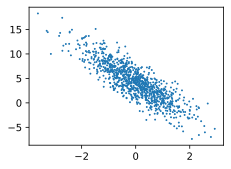

In [ ]:
d2l.set_figsize()
# detach() 的作用是将张量从计算图中分离出来，得到一个新的张量，这个新张量不再需要计算梯度。
# 这样做通常是为了在不影响反向传播的情况下，将数据转换为 numpy 格式用于可视化或分析。
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

In [14]:
# yield 是 Python 的生成器语法，用于在函数中返回一个值，并在下次迭代时从上一次返回的位置继续执行。
# 这样可以节省内存，适合处理大量数据的场景。
# random.shuffle 是 Python 标准库 random 中的一个函数，用于将一个序列（如列表）中的元素随机打乱顺序。
# indices = list(range(num_examples)) 的作用是生成一个从 0 到 num_examples-1 的整数列表，
# 这样可以方便地对样本的索引进行随机打乱，实现小批量数据的随机采样。
# 这个 data_iter 函数的意义在于：每次调用时，都会随机打乱数据顺序，并按 batch_size 返回一批特征和标签，
# 用于小批量梯度下降等优化算法的数据读取。
# features 表示特征，是输入数据，每一行对应一个样本的特征向量（如二维特征：[x1, x2]）。
# labels 表示标签，是每个样本对应的真实输出（如回归问题中的目标值y）。
# 在本例中，features 是一个形状为 (样本数, 特征数) 的张量，labels 是一个形状为 (样本数, 1) 的张量。

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成样本索引列表
    random.shuffle(indices)  # 随机打乱索引，实现数据的随机采样
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]
        )
        # yield 语句返回当前批次的数据，下次迭代时从这里继续
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.8930, -0.0209],
        [-1.0424, -0.6384],
        [ 0.9426,  0.4089],
        [ 0.2770, -0.8869],
        [-0.3161,  1.9249],
        [ 0.0297,  0.6360],
        [ 0.1609, -0.6031],
        [ 0.6679,  1.4966],
        [ 1.3308,  0.0754],
        [ 0.2246, -0.9114]]) 
 tensor([[ 2.4833],
        [ 4.2859],
        [ 4.6832],
        [ 7.7581],
        [-2.9652],
        [ 2.0928],
        [ 6.5667],
        [ 0.4600],
        [ 6.6127],
        [ 7.7293]])


In [26]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
w,b,X

(tensor([[ 0.0066],
         [-0.0087]], requires_grad=True),
 tensor([0.], requires_grad=True),
 tensor([[-0.8930, -0.0209],
         [-1.0424, -0.6384],
         [ 0.9426,  0.4089],
         [ 0.2770, -0.8869],
         [-0.3161,  1.9249],
         [ 0.0297,  0.6360],
         [ 0.1609, -0.6031],
         [ 0.6679,  1.4966],
         [ 1.3308,  0.0754],
         [ 0.2246, -0.9114]]))

In [27]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b
# torch.matmul(X,w)
linreg(X,w,b),b

(tensor([[-0.0057],
         [-0.0013],
         [ 0.0026],
         [ 0.0095],
         [-0.0187],
         [-0.0053],
         [ 0.0063],
         [-0.0086],
         [ 0.0081],
         [ 0.0094]], grad_fn=<AddBackward0>),
 tensor([0.], requires_grad=True))

In [28]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [ ]:
def sgd(params, lr, batch_size):
    """
    随机梯度下降（SGD）优化算法的实现。

    参数说明：
    params: 需要优化的参数集合（如模型的权重w和偏置b），通常是一个可迭代对象（如列表）。
    lr: 学习率（learning rate），控制每次参数更新的步长。
    batch_size: 小批量的样本数，用于对梯度进行平均，保证不同批量大小下的学习率效果一致。

    随机梯度下降的"随机"体现在哪？
    1. 数据采样的随机性：在 data_iter 函数中，通过 random.shuffle(indices) 随机打乱样本顺序，
       每个epoch都会以不同的顺序遍历数据，这是"随机"的主要体现。
    2. 小批量选择的随机性：每次迭代只使用一个小批量（batch）的数据来计算梯度，而不是使用全部数据。
       由于数据顺序被随机打乱，每个batch包含的样本组合都是随机的。
    3. 梯度估计的随机性：由于每次只用部分数据计算梯度，得到的梯度是对真实梯度的一个有噪声的估计，
       这种噪声具有随机性，但期望值等于真实梯度。

    注意：本函数只负责参数更新，"随机"特性主要体现在数据采样阶段（data_iter函数）。

    with torch.no_grad() 的作用：
    在该代码块下，所有涉及到的张量计算都不会被 autograd 记录，也不会构建计算图。
    这样可以避免在参数更新时影响梯度的计算和反向传播，提高效率并节省内存。

    torch.no_grad 是 PyTorch 提供的上下文管理器，用于关闭自动求导机制，常用于模型推理和参数更新阶段。

    具体实现：
    对每个参数 param，按照SGD公式 param = param - lr * param.grad / batch_size 进行更新。
    更新后，使用 param.grad.zero_() 将该参数的梯度清零，为下一轮迭代做准备。
    """
    with torch.no_grad():  # 关闭自动求导机制，防止参数更新被记录进计算图
        for param in params:
            param -= lr * param.grad / batch_size  # 按照SGD公式更新参数
            param.grad.zero_()  # 梯度清零

In [31]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

# 结合反向传播的过程，为什么backward()要求输入为标量？
# 在PyTorch中，反向传播的本质是根据损失函数对模型参数求梯度。
# 损失函数通常是一个标量（如均方误差的总和或平均值），代表了当前模型整体的误差。
# 只有当损失是标量时，链式法则才能从损失出发，逐层向前传播，计算出每个参数的梯度。
# 如果损失是一个向量（如每个样本的损失），PyTorch无法自动推断如何将这些损失合并为一个标量来进行梯度回传。
# 因此，我们通常会对每个batch的损失求和（或取平均），得到一个标量，再调用backward()。
# 这样，autograd才能正确地构建计算图，并通过链式法则计算出所有参数的梯度，完成参数的更新。
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # l是一个batch中每个样本的损失组成的向量（形状为[batch_size, 1]）
        # 需要对l求和，得到一个标量损失，才能进行反向传播
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch+1},loss{float(train_l.sum())}')

epoch1,loss42.02961349487305
epoch2,loss0.16582103073596954
epoch3,loss0.0502144880592823
